In [1]:
import os
import torch
from copy import deepcopy
import numpy as np
import xarray as xr
import pandas as pd
import torch.nn as nn
import random
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
from sklearn import preprocessing
import zipfile
import shutil
from sklearn.preprocessing import StandardScaler
import math
device = 'cuda' if torch.cuda.is_available() else 'cpu'   
device

'cuda'

In [2]:
def set_seed(seed = 427):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)

In [3]:
class EarthDataSet(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data['sst'])

    def __getitem__(self, idx):   
        return (self.data['sst'][idx], self.data['t300'][idx], self.data['ua'][idx], self.data['va'][idx]), self.data['label'][idx]

In [4]:
def fit_data(data_list, fit=True):
    a,b,c,d = data_list[0].shape
    all_data = []
    for data in data_list:
        new_data = data.reshape(-1)
        all_data.append(new_data)
    all_data = np.stack(all_data,1)
    print(all_data.shape)
    if fit:
        standardScaler.fit(all_data)
        print("fit train data")
    all_data = standardScaler.transform(all_data)
    res_data = []
    for i in range(all_data.shape[1]):
        data = all_data[:,i].reshape(a,b,c,d)
        res_data.append(data)
    return res_data

In [5]:
def load_data():
    # CMIP data    
    train = xr.open_dataset('tcdata/enso_round1_train_20210201/CMIP_train.nc')
    label = xr.open_dataset('tcdata/enso_round1_train_20210201/CMIP_label.nc')    
   
    train_sst = train['sst'][:, :12].values  # (4645, 12, 24, 72)
    train_t300 = train['t300'][:, :12].values
    train_ua = train['ua'][:, :12].values
    train_va = train['va'][:, :12].values
    train_label = label['nino'][:, 12:36].values

    train_ua = np.nan_to_num(train_ua) # trans nan to 0
    train_va = np.nan_to_num(train_va)
    train_t300 = np.nan_to_num(train_t300)
    train_sst = np.nan_to_num(train_sst)
    
    data_list = [train_sst,train_t300,train_ua,train_va]
    train_sst,train_t300,train_ua,train_va = fit_data(data_list, fit=True)

    # SODA data    
    train2 = xr.open_dataset('tcdata/enso_round1_train_20210201/SODA_train.nc')
    label2 = xr.open_dataset('tcdata/enso_round1_train_20210201/SODA_label.nc')
    
    train_sst2 = train2['sst'][:, :12].values  # (100, 12, 24, 72)
    train_t3002 = train2['t300'][:, :12].values
    train_ua2 = train2['ua'][:, :12].values
    train_va2 = train2['va'][:, :12].values
    train_label2 = label2['nino'][:, 12:36].values
    
    train_sst2 = np.nan_to_num(train_sst2) # trans nan to 0
    train_t3002 = np.nan_to_num(train_t3002)
    train_ua2 = np.nan_to_num(train_ua2)
    train_va2 = np.nan_to_num(train_va2)
    
    data_list = [train_sst2,train_t3002,train_ua2,train_va2]
    train_sst2,train_t3002,train_ua2,train_va2 = fit_data(data_list, fit=False)

    print('Train samples: {}, Valid samples: {}'.format(len(train_label), len(train_label2)))

    dict_train = {
        'sst':train_sst,
        't300':train_t300,
        'ua':train_ua,
        'va': train_va,
        'label': train_label}
    dict_valid = {
        'sst':train_sst2,
        't300':train_t3002,
        'ua':train_ua2,
        'va': train_va2,
        'label': train_label2}
    train_dataset = EarthDataSet(dict_train)
    valid_dataset = EarthDataSet(dict_valid)
    return train_dataset, valid_dataset

In [6]:
set_seed()
standardScaler = StandardScaler()
train_dataset, valid_dataset = load_data()      
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

(96318720, 4)
fit train data
(2073600, 4)
Train samples: 4645, Valid samples: 100


In [7]:
def coreff(x, y):
    x_mean = np.mean(x)
    y_mean = np.mean(y)
    c1 = sum((x - x_mean) * (y - y_mean))
    c2 = sum((x - x_mean)**2) * sum((y - y_mean)**2)
    return c1/np.sqrt(c2)

def rmse(preds, y):
    r = np.sqrt(sum((preds - y)**2) / preds.shape[0])
    return r

def eval_score(preds, label):
    acskill_socre = 0
    rmse_score = 0
    a = [1.5]*4 + [2]*7 + [3]*7 + [4]*6
    for i in range(24):
        r = rmse(preds[:, i], label[:, i], ) # T时刻 (100,)
        cor = coreff(preds[:, i], label[:, i], )
    
        rmse_score += r
        acskill_socre += a[i] * np.log(i+1) * cor
    print("acskill_socre:{}, rmse_score:{}".format(2/3*acskill_socre, rmse_score))
    return 2/3 * acskill_socre - rmse_score

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

In [9]:
def train(num_epochs):
    best_score = -99
    loss_epoch = []
    
    epoch = -1
    model.eval()
    y_true, y_pred = [], []
    for step, ((sst, t300, ua, va), label) in enumerate(valid_loader):
        sst = sst.to(device).float()
        t300 = t300.to(device).float()
        ua = ua.to(device).float()
        va = va.to(device).float()
        label = label.to(device).float()
        preds = model(sst, t300, ua, va)

        y_pred.append(preds)
        y_true.append(label)

    y_true = torch.cat(y_true, axis=0).cpu().detach().numpy()
    y_pred = torch.cat(y_pred, axis=0).cpu().detach().numpy()
    x_month = np.arange(24)
    score = eval_score(y_true, y_pred)
    print('Epoch: {}, Valid Score: {}\n'.format(epoch+1,score))    
        
    for epoch in range(num_epochs):
        model.train()
        all_loss = []
        for step, ((sst, t300, ua, va), label) in enumerate(train_loader):                
            sst = sst.to(device).float()
            t300 = t300.to(device).float()
            ua = ua.to(device).float()
            va = va.to(device).float()
            optimizer.zero_grad()
            label = label.to(device).float()
            preds = model(sst, t300, ua, va)
            loss = loss_fn(preds, label)
            loss.backward()
            optimizer.step()
            all_loss.append(loss.item())
            if step%20 == 0:
                print('Step: {}, Train Loss: {}'.format(step, loss))
        print('Epoch: {}, Train loss: {}'.format(epoch+1, np.mean(all_loss)))
        loss_epoch.append(np.mean(all_loss))

        model.eval()
        y_true, y_pred = [], []
        for step, ((sst, t300, ua, va), label) in enumerate(valid_loader):
            sst = sst.to(device).float()
            t300 = t300.to(device).float()
            ua = ua.to(device).float()
            va = va.to(device).float()
            label = label.to(device).float()
            preds = model(sst, t300, ua, va)

            y_pred.append(preds)
            y_true.append(label)

        y_true = torch.cat(y_true, axis=0).cpu().detach().numpy()
        y_pred = torch.cat(y_pred, axis=0).cpu().detach().numpy()
        x_month = np.arange(24)
        score = eval_score(y_true, y_pred)
        print('Epoch: {}, Valid Score: {}'.format(epoch+1,score))
        
        torch.save(model.state_dict(), './models/basemodel_epoch_{}.pt'.format(epoch+1))
        if score > best_score:
            torch.save(model.state_dict(), './models/basemodel_best.pt')
            print('Model saved successfully')
            best_score = score
            
        # figure
        plt.figure(figsize = (10,5))
        for i in range(24):
            plt.subplot(5,5,i+1)
            plt.plot(x_month, y_true[i],color='red')
            plt.plot(x_month, y_pred[i],color='blue')
        plt.subplot(5,5,25)
        plt.plot(np.arange(len(loss_epoch)),loss_epoch)
        plt.tight_layout()
        plt.show()
        

In [10]:
def gelu(x):
    """ Original Implementation of the gelu activation function in Google Bert repo when initialy created.
        For information: OpenAI GPT's gelu is slightly different (and gives slightly different results):
        0.5 * x * (1 + torch.tanh(math.sqrt(2 / math.pi) * (x + 0.044715 * torch.pow(x, 3))))
        Also see https://arxiv.org/abs/1606.08415
    """
    return x * 0.5 * (1.0 + torch.erf(x / math.sqrt(2.0)))

class Mlp(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=gelu, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x
    
class Attention(nn.Module):
    def __init__(self, dim, num_heads=8, qkv_bias=False, qk_scale=None, attn_drop=0., proj_drop=0.):
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        # NOTE scale factor was wrong in my original version, can set manually to be compat with prev weights
        self.scale = qk_scale or head_dim ** -0.5

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)
        self.mat = torch.matmul

    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]   # make torchscript happy (cannot use tensor as tuple)

        attn = (self.mat(q, k.transpose(-2, -1))) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        x = self.mat(attn, v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x
    
class Block(nn.Module):

    def __init__(self, dim, num_heads, mlp_ratio=4., qkv_bias=False, qk_scale=None, proj_drop=0., attn_drop=0.,
                 drop_path=0., act_layer=gelu, norm_layer=nn.LayerNorm):
        super().__init__()
        self.norm1 = norm_layer(dim)
        self.attn = Attention(
            dim, num_heads=num_heads, qkv_bias=qkv_bias, qk_scale=qk_scale, attn_drop=attn_drop, proj_drop=proj_drop)
        # NOTE: drop path for stochastic depth, we shall see if this is better than dropout here
#         self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=proj_drop)

    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x


In [12]:
class CNN_Model(nn.Module):
    def __init__(self, embed_dim=128):
        super(CNN_Model, self).__init__()

        resnet = models.resnet18()
        resnet.conv1 = nn.Conv2d(4, 64, kernel_size=(4, 8), stride=(1, 1), padding=(2, 4), bias=False)
        resnet.maxpool = nn.MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
#         resnet.fc = nn.Linear(resnet.fc.in_features, 256)
        self.resnet = nn.Sequential(*(list(resnet.children())[:-1]))
#         nn.MultiheadAttention(embed_dim = 512, num_heads = 8, dropout=0.0, bias=True)
        
        self.block = Block(dim=512, num_heads=8)
        self.norm = nn.LayerNorm(512)
        self.avgpool = nn.AvgPool1d(12)
        
        # Classifier head
        self.head = nn.Linear(512, 24)
        
    def forward_features(self, x):
        
        x = self.block(x)
        x = self.norm(x)
        return x

    def forward(self, sst, t300, ua, va):
        x = torch.cat([sst.unsqueeze(2), t300.unsqueeze(2), ua.unsqueeze(2), va.unsqueeze(2)], dim=2) # b * 12 * 4 * 24 * 72
        seq = []
        for t in range(x.shape[1]):
            t_i = x[:,t,:,:,:] # b * 4 * 24 * 72
            t_i = self.resnet(t_i).squeeze(-1).squeeze(-1) #  # b * 521
#             t_i = torch.flatten(t_i, start_dim=1)
            seq.append(t_i)
        x = torch.stack(seq).transpose(0,1) # b * 12 * 521
        x = self.forward_features(x)
        x = self.avgpool(x.transpose(1,2)).squeeze(-1) # b * 512
        x = self.head(x)  # b * 24
        return x

In [13]:
model = CNN_Model()
device = 'cuda' if torch.cuda.is_available() else 'cpu'   
optimizer = torch.optim.Adam(model.parameters(), lr=8e-5)
loss_fn = nn.MSELoss()

model = model.to(device)
loss_fn = loss_fn.to(device)

In [14]:
print('{} : all params: {:4f}M'.format(model._get_name(), sum(p.numel() for p in model.parameters()) / 1000 / 1000))

CNN_Model : all params: 14.339480M


In [15]:
model

CNN_Model(
  (resnet): Sequential(
    (0): Conv2d(4, 64, kernel_size=(4, 8), stride=(1, 1), padding=(2, 4), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True

acskill_socre:-3.838203137401104, rmse_score:23.29316087808042
Epoch: 0, Valid Score: -27.131364015481523

Step: 0, Train Loss: 0.9009591937065125
Step: 20, Train Loss: 0.670392632484436
Step: 40, Train Loss: 0.6090454459190369
Step: 60, Train Loss: 0.6457482576370239
Step: 80, Train Loss: 0.5285117626190186
Step: 100, Train Loss: 0.5266481041908264
Step: 120, Train Loss: 0.44298848509788513
Step: 140, Train Loss: 0.5679135322570801
Epoch: 1, Train loss: 0.5926945750435738
acskill_socre:11.98612939549956, rmse_score:20.200863253413065
Epoch: 1, Valid Score: -8.214733857913505
Model saved successfully


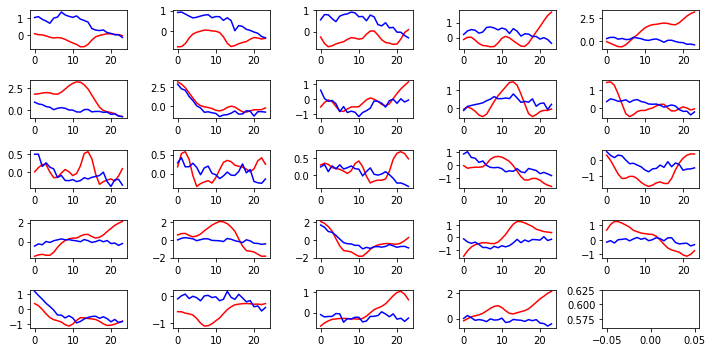

Step: 0, Train Loss: 0.40740537643432617
Step: 20, Train Loss: 0.34588369727134705
Step: 40, Train Loss: 0.3008663058280945
Step: 60, Train Loss: 0.3736942708492279
Step: 80, Train Loss: 0.6278072595596313
Step: 100, Train Loss: 0.4229305684566498
Step: 120, Train Loss: 0.33311355113983154
Step: 140, Train Loss: 0.5120439529418945
Epoch: 2, Train loss: 0.41607960772840946
acskill_socre:14.100695251948167, rmse_score:19.67099685568664
Epoch: 2, Valid Score: -5.570301603738471
Model saved successfully


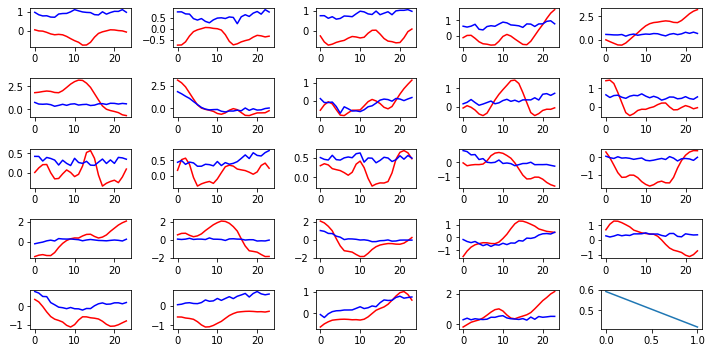

Step: 0, Train Loss: 0.4183109998703003
Step: 20, Train Loss: 0.21681885421276093
Step: 40, Train Loss: 0.20471428334712982
Step: 60, Train Loss: 0.18978822231292725
Step: 80, Train Loss: 0.2164658010005951
Step: 100, Train Loss: 0.26757240295410156
Step: 120, Train Loss: 0.23873667418956757
Step: 140, Train Loss: 0.20894967019557953
Epoch: 3, Train loss: 0.2464869649034657
acskill_socre:21.673240699123276, rmse_score:21.278161887966657
Epoch: 3, Valid Score: 0.395078811156619
Model saved successfully


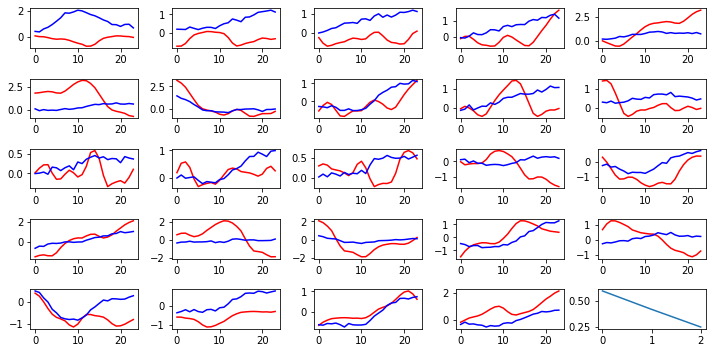

Step: 0, Train Loss: 0.17913083732128143
Step: 20, Train Loss: 0.14428770542144775
Step: 40, Train Loss: 0.18975591659545898
Step: 60, Train Loss: 0.15677712857723236
Step: 80, Train Loss: 0.1552821397781372
Step: 100, Train Loss: 0.17402639985084534
Step: 120, Train Loss: 0.20455484092235565
Step: 140, Train Loss: 0.1406298130750656
Epoch: 4, Train loss: 0.16252658893800762
acskill_socre:14.747530917086106, rmse_score:22.32101215952028
Epoch: 4, Valid Score: -7.573481242434173


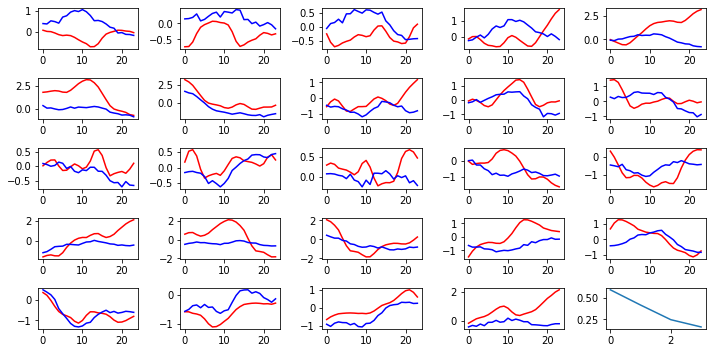

Step: 0, Train Loss: 0.10271160304546356
Step: 20, Train Loss: 0.07293963432312012
Step: 40, Train Loss: 0.12360107898712158
Step: 60, Train Loss: 0.1283038854598999
Step: 80, Train Loss: 0.1717219352722168
Step: 100, Train Loss: 0.09455879777669907
Step: 120, Train Loss: 0.15586864948272705
Step: 140, Train Loss: 0.0853513702750206
Epoch: 5, Train loss: 0.10784932746462626
acskill_socre:19.70856900594928, rmse_score:20.046773970786926
Epoch: 5, Valid Score: -0.3382049648376473


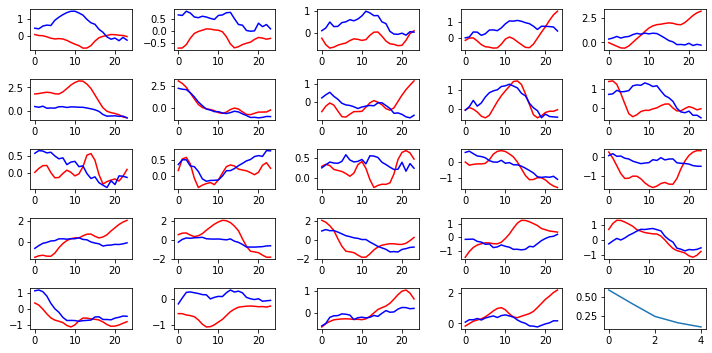

Step: 0, Train Loss: 0.07581324130296707
Step: 20, Train Loss: 0.0910256952047348
Step: 40, Train Loss: 0.05919015407562256
Step: 60, Train Loss: 0.06833838671445847
Step: 80, Train Loss: 0.055228374898433685
Step: 100, Train Loss: 0.10608037561178207
Step: 120, Train Loss: 0.08917014300823212
Step: 140, Train Loss: 0.06559260934591293
Epoch: 6, Train loss: 0.07476763166997531
acskill_socre:20.95170564140356, rmse_score:20.47901487745823
Epoch: 6, Valid Score: 0.47269076394533016
Model saved successfully


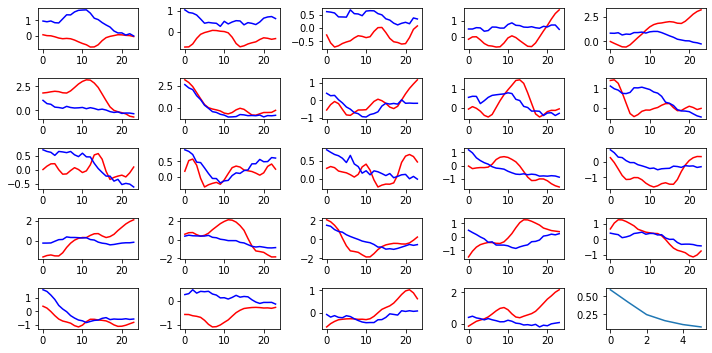

Step: 0, Train Loss: 0.05136823654174805
Step: 20, Train Loss: 0.05304374918341637
Step: 40, Train Loss: 0.05418996140360832
Step: 60, Train Loss: 0.05347059667110443
Step: 80, Train Loss: 0.05021711811423302
Step: 100, Train Loss: 0.06144319102168083
Step: 120, Train Loss: 0.04156467318534851
Step: 140, Train Loss: 0.04279864951968193
Epoch: 7, Train loss: 0.06096340391835938
acskill_socre:22.45492989836211, rmse_score:19.66467513317402
Epoch: 7, Valid Score: 2.7902547651880916
Model saved successfully


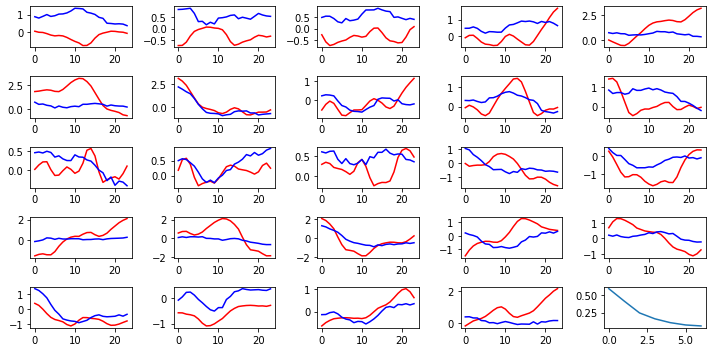

Step: 0, Train Loss: 0.04875937104225159
Step: 20, Train Loss: 0.06779730319976807
Step: 40, Train Loss: 0.08391036093235016
Step: 60, Train Loss: 0.048211753368377686
Step: 80, Train Loss: 0.049387574195861816
Step: 100, Train Loss: 0.053335100412368774
Step: 120, Train Loss: 0.046206362545490265
Step: 140, Train Loss: 0.049991052597761154
Epoch: 8, Train loss: 0.058879203954073665
acskill_socre:18.273210688029366, rmse_score:20.171134860703617
Epoch: 8, Valid Score: -1.8979241726742515


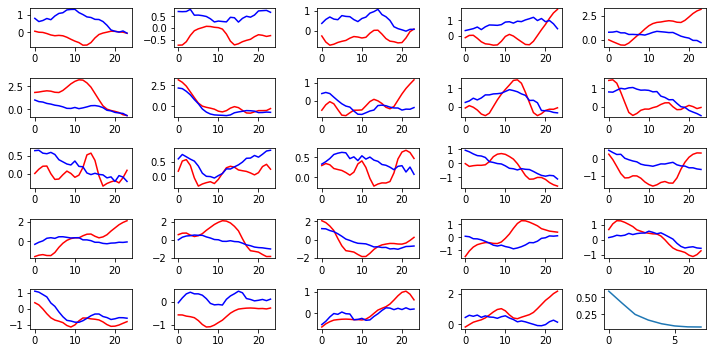

Step: 0, Train Loss: 0.04287835955619812
Step: 20, Train Loss: 0.08530765771865845
Step: 40, Train Loss: 0.04661004990339279
Step: 60, Train Loss: 0.0415588840842247
Step: 80, Train Loss: 0.07511558383703232
Step: 100, Train Loss: 0.06510761380195618
Step: 120, Train Loss: 0.08107303828001022
Step: 140, Train Loss: 0.0490516722202301
Epoch: 9, Train loss: 0.055733045091061556
acskill_socre:20.268358970521998, rmse_score:20.79201448987958
Epoch: 9, Valid Score: -0.5236555193575825


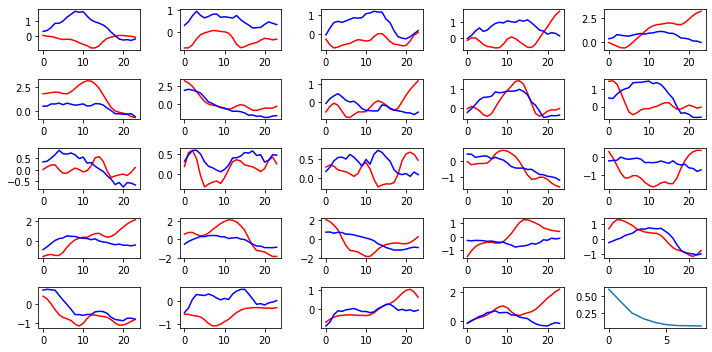

Step: 0, Train Loss: 0.0585530623793602
Step: 20, Train Loss: 0.04743863269686699
Step: 40, Train Loss: 0.0745895653963089
Step: 60, Train Loss: 0.03761034831404686
Step: 80, Train Loss: 0.03399384021759033
Step: 100, Train Loss: 0.060538411140441895
Step: 120, Train Loss: 0.03268824517726898
Step: 140, Train Loss: 0.03512492775917053
Epoch: 10, Train loss: 0.04870611458557517
acskill_socre:18.723828008889104, rmse_score:20.603293496444866
Epoch: 10, Valid Score: -1.8794654875557626


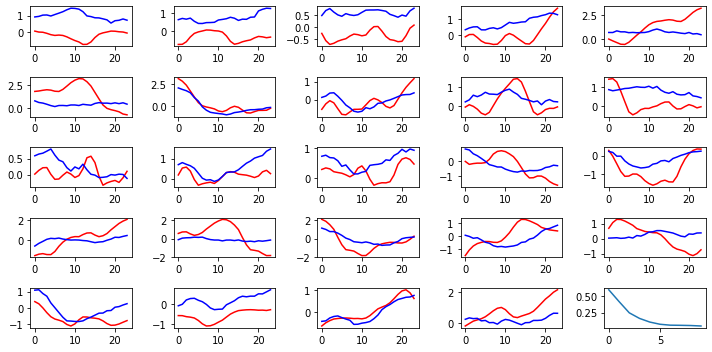

Step: 0, Train Loss: 0.07944398373365402
Step: 20, Train Loss: 0.05102395638823509
Step: 40, Train Loss: 0.045394282788038254
Step: 60, Train Loss: 0.03701149299740791
Step: 80, Train Loss: 0.036576397716999054
Step: 100, Train Loss: 0.0792110413312912
Step: 120, Train Loss: 0.09592941403388977
Step: 140, Train Loss: 0.03733629733324051
Epoch: 11, Train loss: 0.055896533028005735
acskill_socre:25.29998144429993, rmse_score:19.876807883951713
Epoch: 11, Valid Score: 5.423173560348218
Model saved successfully


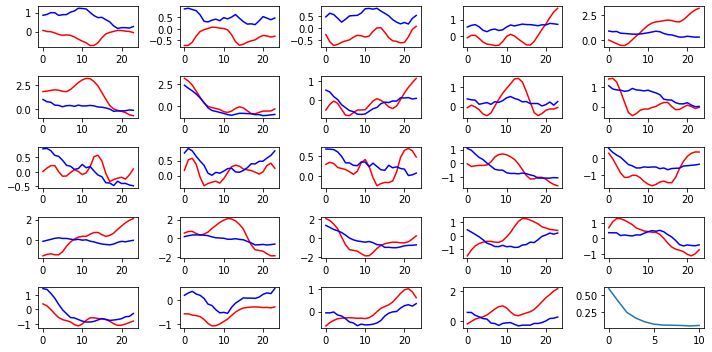

Step: 0, Train Loss: 0.039052702486515045
Step: 20, Train Loss: 0.07874984294176102
Step: 40, Train Loss: 0.07729645073413849
Step: 60, Train Loss: 0.03952862322330475
Step: 80, Train Loss: 0.07265122979879379
Step: 100, Train Loss: 0.03941595181822777
Step: 120, Train Loss: 0.04585486650466919
Step: 140, Train Loss: 0.06090058013796806
Epoch: 12, Train loss: 0.056639278677534564
acskill_socre:17.349730058642372, rmse_score:21.004496059030867
Epoch: 12, Valid Score: -3.654766000388495


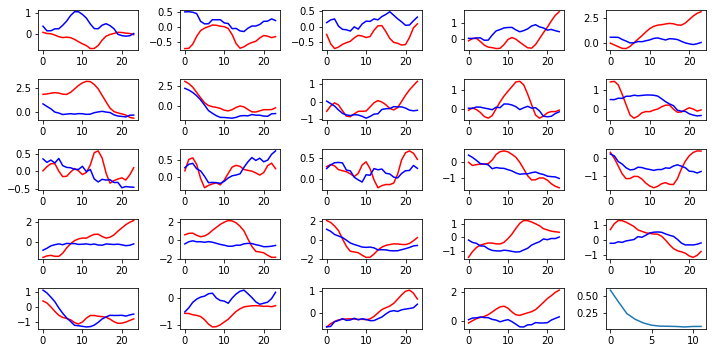

Step: 0, Train Loss: 0.058261752128601074
Step: 20, Train Loss: 0.06809371709823608
Step: 40, Train Loss: 0.05953209847211838
Step: 60, Train Loss: 0.048337772488594055
Step: 80, Train Loss: 0.06365988403558731
Step: 100, Train Loss: 0.05056405067443848
Step: 120, Train Loss: 0.046917688101530075
Step: 140, Train Loss: 0.03340432792901993
Epoch: 13, Train loss: 0.05700121702600832
acskill_socre:20.76875083364117, rmse_score:19.831893232577436
Epoch: 13, Valid Score: 0.9368576010637355


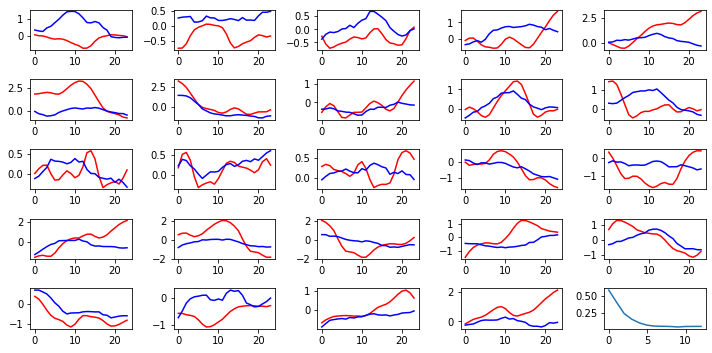

Step: 0, Train Loss: 0.05836844444274902
Step: 20, Train Loss: 0.08246811479330063
Step: 40, Train Loss: 0.0626828745007515
Step: 60, Train Loss: 0.058034058660268784
Step: 80, Train Loss: 0.03755895793437958
Step: 100, Train Loss: 0.05293455719947815
Step: 120, Train Loss: 0.05415460467338562
Step: 140, Train Loss: 0.048947952687740326
Epoch: 14, Train loss: 0.05088222984938997
acskill_socre:19.9277197547825, rmse_score:20.645868872995912
Epoch: 14, Valid Score: -0.718149118213411


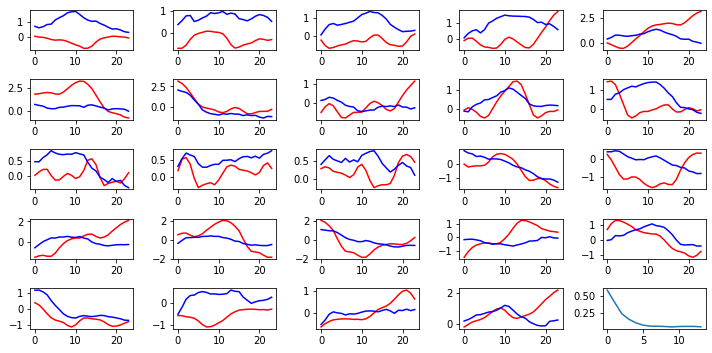

Step: 0, Train Loss: 0.03478889912366867
Step: 20, Train Loss: 0.05911507457494736
Step: 40, Train Loss: 0.10020103305578232
Step: 60, Train Loss: 0.02682488225400448
Step: 80, Train Loss: 0.07184416055679321
Step: 100, Train Loss: 0.0674247071146965
Step: 120, Train Loss: 0.024919748306274414
Step: 140, Train Loss: 0.0435967743396759
Epoch: 15, Train loss: 0.05018309795948332
acskill_socre:25.4106323163431, rmse_score:19.66936408988041
Epoch: 15, Valid Score: 5.74126822646269
Model saved successfully


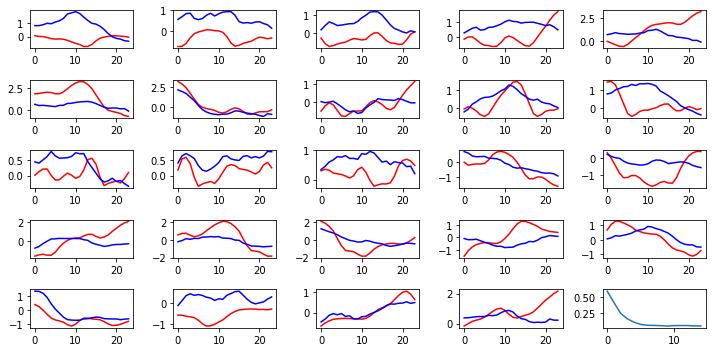

Step: 0, Train Loss: 0.05815126746892929
Step: 20, Train Loss: 0.07951362431049347
Step: 40, Train Loss: 0.03770580515265465
Step: 60, Train Loss: 0.029896866530179977
Step: 80, Train Loss: 0.04218980669975281
Step: 100, Train Loss: 0.04663128778338432
Step: 120, Train Loss: 0.03402414172887802
Step: 140, Train Loss: 0.053923994302749634
Epoch: 16, Train loss: 0.045401276676111844
acskill_socre:22.453121580032334, rmse_score:19.750441672423843
Epoch: 16, Valid Score: 2.7026799076084913


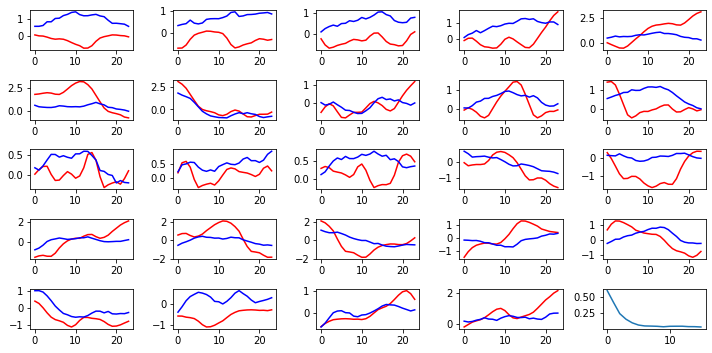

Step: 0, Train Loss: 0.053804706782102585
Step: 20, Train Loss: 0.0455094538629055
Step: 40, Train Loss: 0.02989252470433712
Step: 60, Train Loss: 0.038554415106773376
Step: 80, Train Loss: 0.03480416536331177
Step: 100, Train Loss: 0.043430205434560776
Step: 120, Train Loss: 0.04500870034098625
Step: 140, Train Loss: 0.026857148855924606
Epoch: 17, Train loss: 0.0438167009604712
acskill_socre:19.17235648423229, rmse_score:20.473207714250467
Epoch: 17, Valid Score: -1.3008512300181785


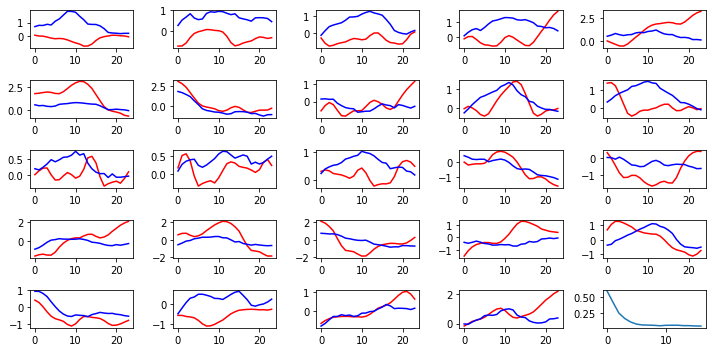

Step: 0, Train Loss: 0.03412236273288727
Step: 20, Train Loss: 0.0427841953933239
Step: 40, Train Loss: 0.031340472400188446
Step: 60, Train Loss: 0.026192864403128624
Step: 80, Train Loss: 0.04156021401286125
Step: 100, Train Loss: 0.030295414850115776
Step: 120, Train Loss: 0.04132901132106781
Step: 140, Train Loss: 0.04217415302991867
Epoch: 18, Train loss: 0.03821468415784918
acskill_socre:21.135900480666713, rmse_score:19.831961465761907
Epoch: 18, Valid Score: 1.303939014904806


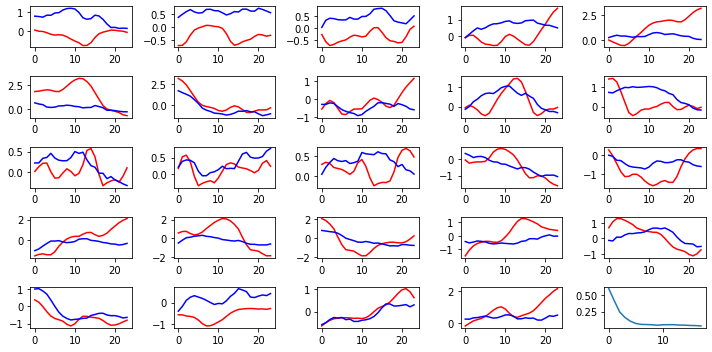

Step: 0, Train Loss: 0.028241505846381187
Step: 20, Train Loss: 0.0479324534535408
Step: 40, Train Loss: 0.06296361982822418
Step: 60, Train Loss: 0.10981430858373642
Step: 80, Train Loss: 0.03834598883986473
Step: 100, Train Loss: 0.03539172559976578
Step: 120, Train Loss: 0.03073694556951523
Step: 140, Train Loss: 0.039010919630527496
Epoch: 19, Train loss: 0.040411502722497675
acskill_socre:18.872222485668825, rmse_score:20.14806258874932
Epoch: 19, Valid Score: -1.275840103080494


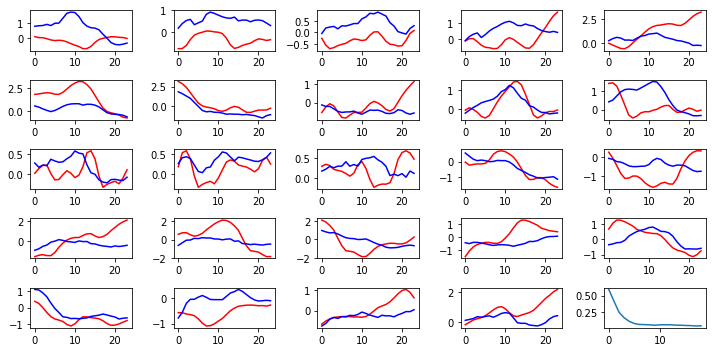

Step: 0, Train Loss: 0.02953735738992691
Step: 20, Train Loss: 0.033431027084589005
Step: 40, Train Loss: 0.05140373855829239
Step: 60, Train Loss: 0.05559815466403961
Step: 80, Train Loss: 0.033177558332681656
Step: 100, Train Loss: 0.04335365816950798
Step: 120, Train Loss: 0.024880148470401764
Step: 140, Train Loss: 0.03236675262451172
Epoch: 20, Train loss: 0.040362999876578376
acskill_socre:18.69014023246023, rmse_score:19.584904091752858
Epoch: 20, Valid Score: -0.8947638592926275


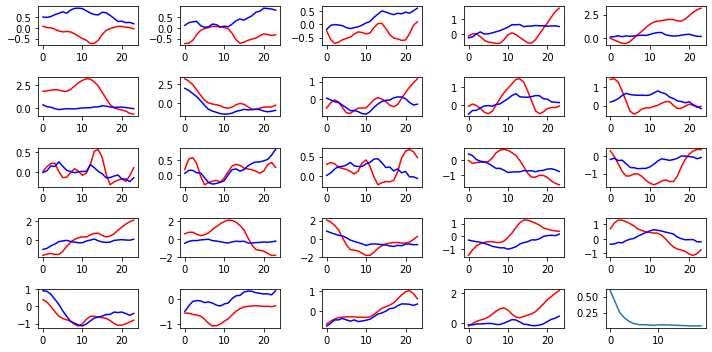

Step: 0, Train Loss: 0.028101369738578796
Step: 20, Train Loss: 0.03366114944219589
Step: 40, Train Loss: 0.0663103312253952
Step: 60, Train Loss: 0.032912611961364746
Step: 80, Train Loss: 0.037359848618507385
Step: 100, Train Loss: 0.03659209609031677
Step: 120, Train Loss: 0.025782957673072815
Step: 140, Train Loss: 0.02342062257230282
Epoch: 21, Train loss: 0.03976923182657729
acskill_socre:19.792090967810466, rmse_score:20.173595677818355
Epoch: 21, Valid Score: -0.38150471000788855


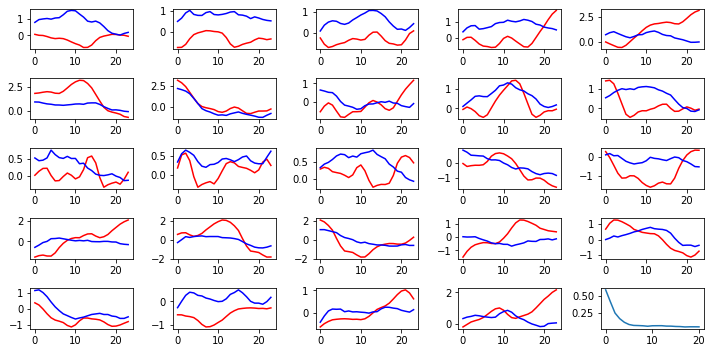

Step: 0, Train Loss: 0.03519676253199577
Step: 20, Train Loss: 0.027584046125411987
Step: 40, Train Loss: 0.0477738194167614
Step: 60, Train Loss: 0.042177170515060425
Step: 80, Train Loss: 0.03087501786649227
Step: 100, Train Loss: 0.025600075721740723
Step: 120, Train Loss: 0.03977781534194946
Step: 140, Train Loss: 0.040886975824832916
Epoch: 22, Train loss: 0.0401794856975544
acskill_socre:20.893744166873642, rmse_score:20.10095673571068
Epoch: 22, Valid Score: 0.7927874311629601


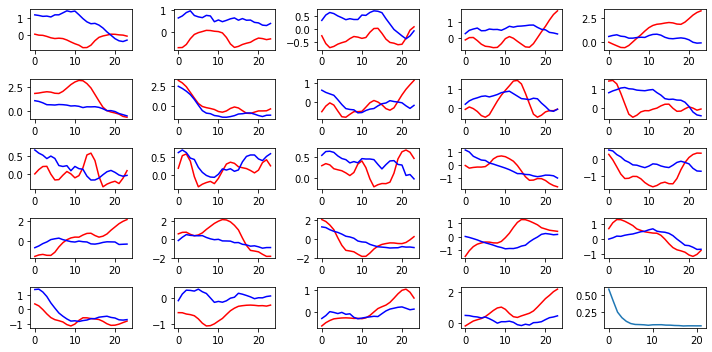

Step: 0, Train Loss: 0.0397193618118763
Step: 20, Train Loss: 0.035601940006017685
Step: 40, Train Loss: 0.039795391261577606
Step: 60, Train Loss: 0.030718516558408737
Step: 80, Train Loss: 0.04054068773984909
Step: 100, Train Loss: 0.04332410544157028
Step: 120, Train Loss: 0.03688788041472435
Step: 140, Train Loss: 0.044341158121824265
Epoch: 23, Train loss: 0.03922827254776677
acskill_socre:20.890034835407924, rmse_score:19.519305433112777
Epoch: 23, Valid Score: 1.3707294022951473


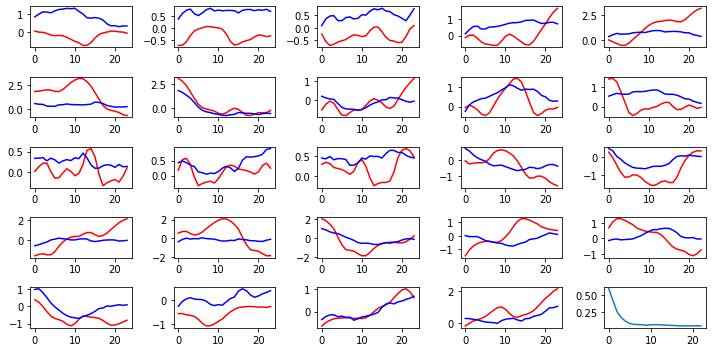

Step: 0, Train Loss: 0.022207994014024734
Step: 20, Train Loss: 0.0389062836766243
Step: 40, Train Loss: 0.054809924215078354
Step: 60, Train Loss: 0.03389707952737808
Step: 80, Train Loss: 0.030835077166557312
Step: 100, Train Loss: 0.030640562996268272
Step: 120, Train Loss: 0.027292994782328606
Step: 140, Train Loss: 0.04395037144422531
Epoch: 24, Train loss: 0.03938897008918328
acskill_socre:18.653865195926404, rmse_score:20.118606765433146
Epoch: 24, Valid Score: -1.4647415695067423


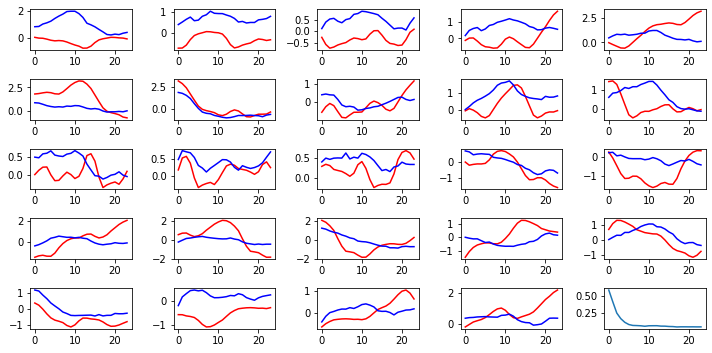

Step: 0, Train Loss: 0.03990653157234192
Step: 20, Train Loss: 0.04316236078739166
Step: 40, Train Loss: 0.07257628440856934
Step: 60, Train Loss: 0.03177949786186218
Step: 80, Train Loss: 0.032557107508182526
Step: 100, Train Loss: 0.02525944635272026
Step: 120, Train Loss: 0.03936048597097397
Step: 140, Train Loss: 0.025928810238838196
Epoch: 25, Train loss: 0.03759426695026764
acskill_socre:18.07967120680587, rmse_score:19.410544433647257
Epoch: 25, Valid Score: -1.330873226841387


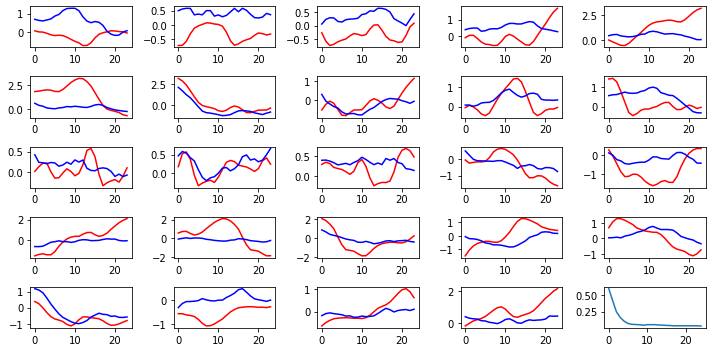

Step: 0, Train Loss: 0.02989071235060692
Step: 20, Train Loss: 0.0417027473449707
Step: 40, Train Loss: 0.04634442180395126
Step: 60, Train Loss: 0.029201369732618332
Step: 80, Train Loss: 0.021572789177298546
Step: 100, Train Loss: 0.0418458990752697
Step: 120, Train Loss: 0.05775830149650574
Step: 140, Train Loss: 0.0507555827498436
Epoch: 26, Train loss: 0.03746353925448166
acskill_socre:20.18399350325135, rmse_score:19.23922862894522
Epoch: 26, Valid Score: 0.9447648743061308


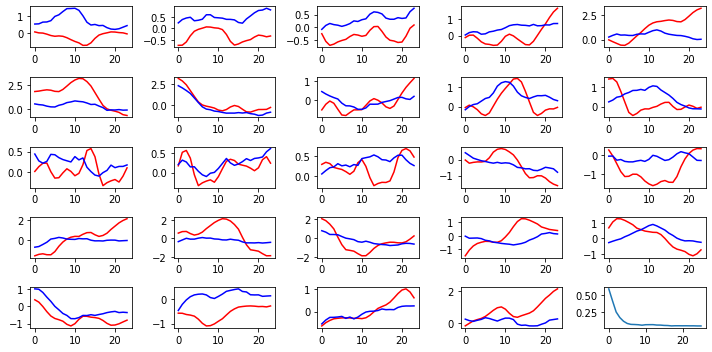

Step: 0, Train Loss: 0.031485021114349365
Step: 20, Train Loss: 0.04722052067518234
Step: 40, Train Loss: 0.031861379742622375
Step: 60, Train Loss: 0.0396282896399498
Step: 80, Train Loss: 0.027238955721259117
Step: 100, Train Loss: 0.03843275457620621
Step: 120, Train Loss: 0.032999735325574875
Step: 140, Train Loss: 0.034760087728500366
Epoch: 27, Train loss: 0.037798136970257926
acskill_socre:19.312047942462904, rmse_score:19.491145204792836
Epoch: 27, Valid Score: -0.1790972623299325


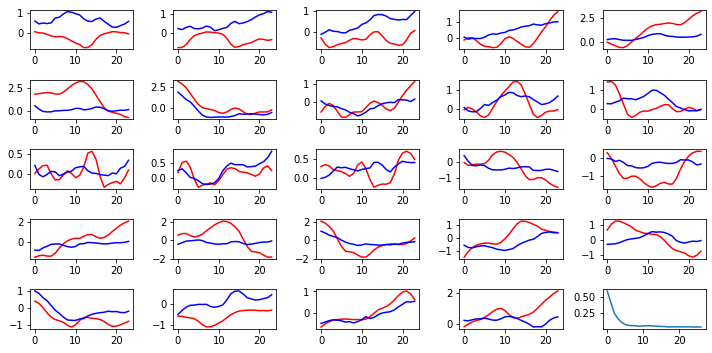

Step: 0, Train Loss: 0.023308342322707176
Step: 20, Train Loss: 0.08032044768333435
Step: 40, Train Loss: 0.055209867656230927
Step: 60, Train Loss: 0.03524041175842285
Step: 80, Train Loss: 0.05694670230150223
Step: 100, Train Loss: 0.028550073504447937
Step: 120, Train Loss: 0.03424340486526489
Step: 140, Train Loss: 0.04349194094538689
Epoch: 28, Train loss: 0.03895574786432394
acskill_socre:19.863516061188513, rmse_score:19.1532164345321
Epoch: 28, Valid Score: 0.7102996266564112


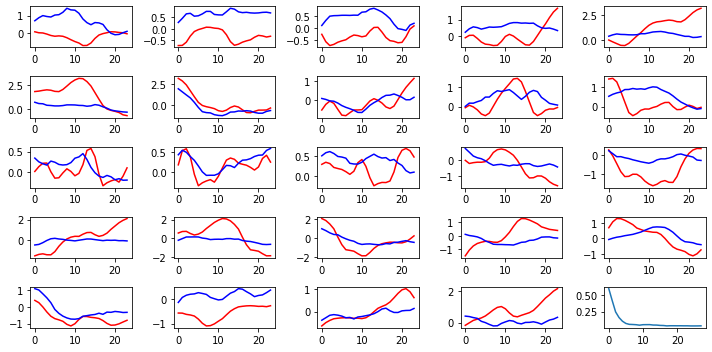

Step: 0, Train Loss: 0.039675772190093994
Step: 20, Train Loss: 0.042258694767951965
Step: 40, Train Loss: 0.030710987746715546
Step: 60, Train Loss: 0.0333920493721962
Step: 80, Train Loss: 0.0492393895983696
Step: 100, Train Loss: 0.028652941808104515
Step: 120, Train Loss: 0.030661627650260925
Step: 140, Train Loss: 0.036010049283504486
Epoch: 29, Train loss: 0.036448194926017766
acskill_socre:19.56636990137391, rmse_score:19.924749819912503
Epoch: 29, Valid Score: -0.3583799185385921


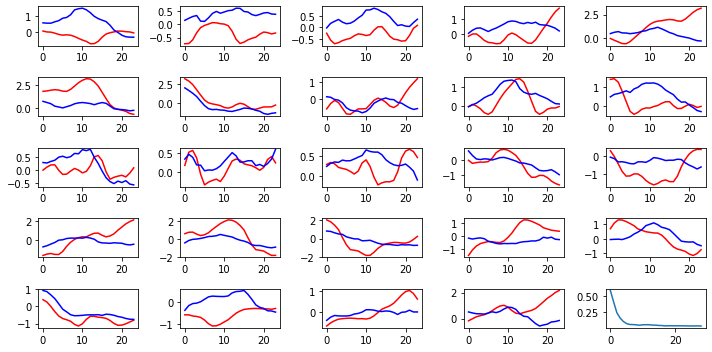

Step: 0, Train Loss: 0.02601393684744835
Step: 20, Train Loss: 0.02740669809281826
Step: 40, Train Loss: 0.06414905935525894
Step: 60, Train Loss: 0.026128491386771202
Step: 80, Train Loss: 0.02749187871813774
Step: 100, Train Loss: 0.029416462406516075
Step: 120, Train Loss: 0.028969651088118553
Step: 140, Train Loss: 0.045553646981716156
Epoch: 30, Train loss: 0.034953317286012926
acskill_socre:17.02839857490474, rmse_score:20.088269106205857
Epoch: 30, Valid Score: -3.059870531301115


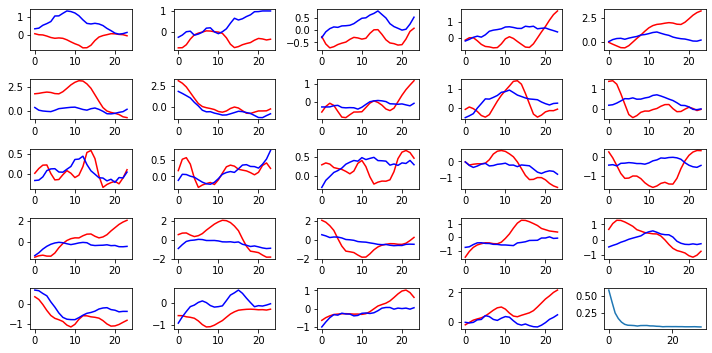

Step: 0, Train Loss: 0.03628656268119812
Step: 20, Train Loss: 0.02861858159303665
Step: 40, Train Loss: 0.0283209215849638
Step: 60, Train Loss: 0.031558480113744736
Step: 80, Train Loss: 0.025399982929229736
Step: 100, Train Loss: 0.022768210619688034
Step: 120, Train Loss: 0.03065713495016098
Step: 140, Train Loss: 0.027790401130914688
Epoch: 31, Train loss: 0.03220184163305245
acskill_socre:16.958347510526604, rmse_score:20.103108809341286
Epoch: 31, Valid Score: -3.1447612988146822


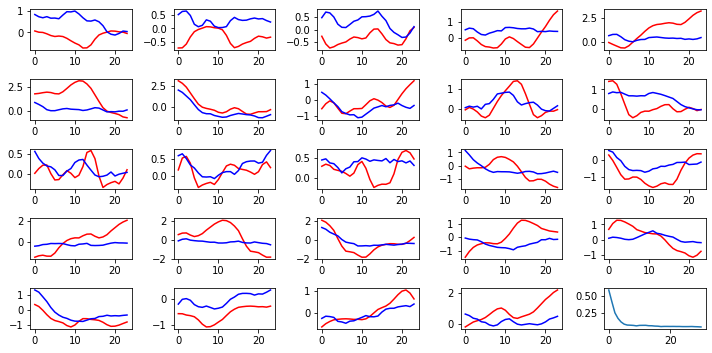

Step: 0, Train Loss: 0.027881629765033722
Step: 20, Train Loss: 0.026193678379058838
Step: 40, Train Loss: 0.04138590395450592
Step: 60, Train Loss: 0.02638103812932968
Step: 80, Train Loss: 0.022681286558508873
Step: 100, Train Loss: 0.0234149768948555
Step: 120, Train Loss: 0.051797449588775635
Step: 140, Train Loss: 0.020518511533737183
Epoch: 32, Train loss: 0.03246993325293472
acskill_socre:18.823998209683012, rmse_score:19.791795410125633
Epoch: 32, Valid Score: -0.9677972004426216


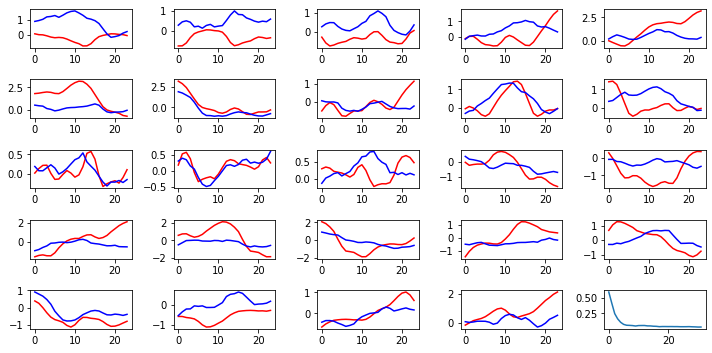

Step: 0, Train Loss: 0.01987873762845993
Step: 20, Train Loss: 0.026589807122945786
Step: 40, Train Loss: 0.03108629584312439
Step: 60, Train Loss: 0.023610321804881096
Step: 80, Train Loss: 0.03887701779603958
Step: 100, Train Loss: 0.024905985221266747
Step: 120, Train Loss: 0.03223119676113129
Step: 140, Train Loss: 0.03247654438018799
Epoch: 33, Train loss: 0.031794118210163015
acskill_socre:20.097245004746384, rmse_score:19.572661880206354
Epoch: 33, Valid Score: 0.5245831245400296


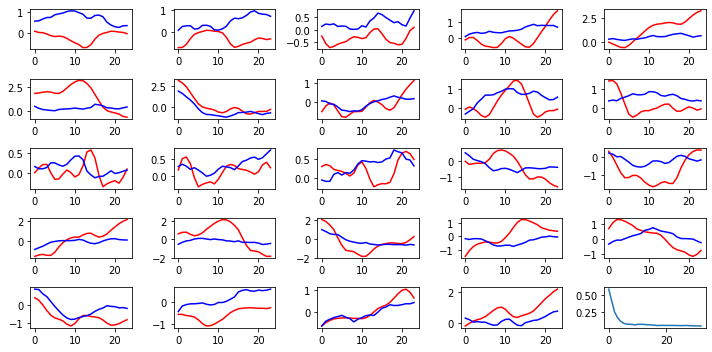

Step: 0, Train Loss: 0.02854158543050289
Step: 20, Train Loss: 0.03165899217128754
Step: 40, Train Loss: 0.020660752430558205
Step: 60, Train Loss: 0.020357079803943634
Step: 80, Train Loss: 0.02050076797604561
Step: 100, Train Loss: 0.02447279542684555
Step: 120, Train Loss: 0.02005133032798767
Step: 140, Train Loss: 0.028482791036367416
Epoch: 34, Train loss: 0.031020205978253116
acskill_socre:18.53567358891384, rmse_score:19.46204163435436
Epoch: 34, Valid Score: -0.926368045440519


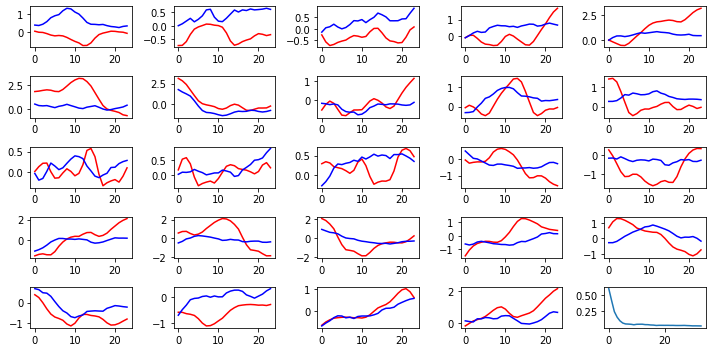

Step: 0, Train Loss: 0.020795738324522972
Step: 20, Train Loss: 0.06450917571783066
Step: 40, Train Loss: 0.021861186251044273
Step: 60, Train Loss: 0.043905071914196014
Step: 80, Train Loss: 0.02749769017100334
Step: 100, Train Loss: 0.029653724282979965
Step: 120, Train Loss: 0.026417192071676254
Step: 140, Train Loss: 0.03735921531915665
Epoch: 35, Train loss: 0.03204867112360997
acskill_socre:16.243998514428526, rmse_score:19.79281098119115
Epoch: 35, Valid Score: -3.548812466762623


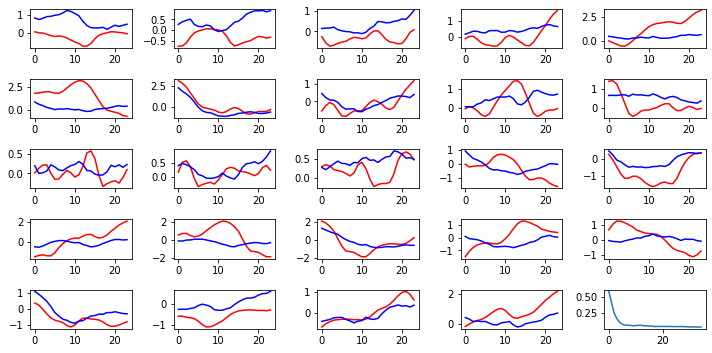

Step: 0, Train Loss: 0.038099609315395355
Step: 20, Train Loss: 0.037087541073560715
Step: 40, Train Loss: 0.0312991663813591
Step: 60, Train Loss: 0.026460137218236923
Step: 80, Train Loss: 0.026081621646881104
Step: 100, Train Loss: 0.03420970216393471
Step: 120, Train Loss: 0.040827371180057526
Step: 140, Train Loss: 0.017205860465765
Epoch: 36, Train loss: 0.03201314581124342
acskill_socre:16.06955113086501, rmse_score:20.132879462831788
Epoch: 36, Valid Score: -4.06332833196678


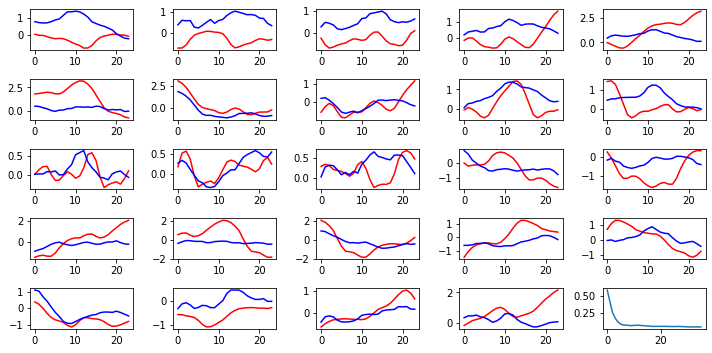

Step: 0, Train Loss: 0.0343208909034729
Step: 20, Train Loss: 0.027272343635559082
Step: 40, Train Loss: 0.01710975356400013
Step: 60, Train Loss: 0.03715050220489502
Step: 80, Train Loss: 0.019606873393058777
Step: 100, Train Loss: 0.029565926641225815
Step: 120, Train Loss: 0.02785937488079071
Step: 140, Train Loss: 0.028193002566695213
Epoch: 37, Train loss: 0.0309860069521588
acskill_socre:20.315752381198585, rmse_score:19.510270996839868
Epoch: 37, Valid Score: 0.8054813843587176


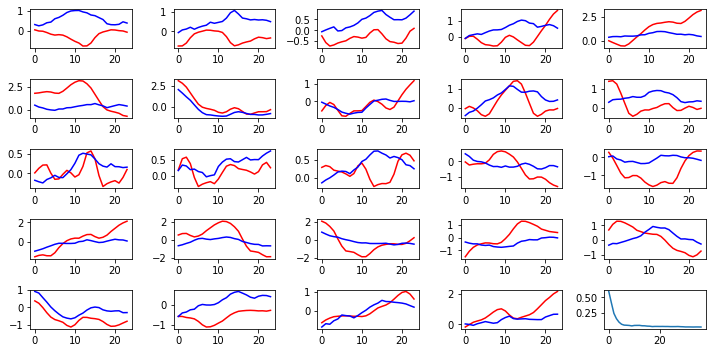

Step: 0, Train Loss: 0.02636914700269699
Step: 20, Train Loss: 0.05018557608127594
Step: 40, Train Loss: 0.028123032301664352
Step: 60, Train Loss: 0.02737133763730526
Step: 80, Train Loss: 0.028136875480413437
Step: 100, Train Loss: 0.0181022547185421
Step: 120, Train Loss: 0.03768578916788101
Step: 140, Train Loss: 0.03426836431026459
Epoch: 38, Train loss: 0.029556319194093142
acskill_socre:16.018119188402338, rmse_score:19.71420944715214
Epoch: 38, Valid Score: -3.696090258749802


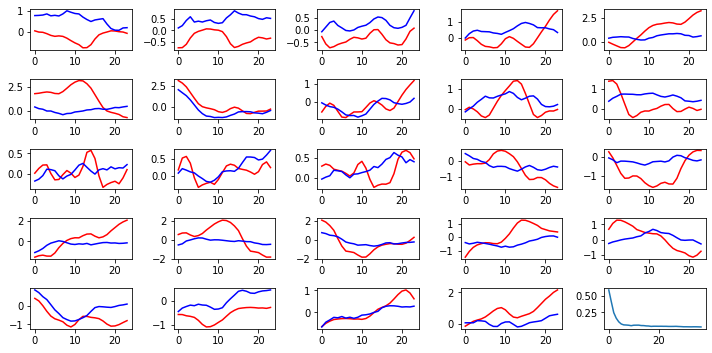

Step: 0, Train Loss: 0.02019811049103737
Step: 20, Train Loss: 0.03511817380785942
Step: 40, Train Loss: 0.03739968687295914
Step: 60, Train Loss: 0.03387634456157684
Step: 80, Train Loss: 0.030121436342597008
Step: 100, Train Loss: 0.02922184392809868
Step: 120, Train Loss: 0.021074291318655014
Step: 140, Train Loss: 0.029184451326727867
Epoch: 39, Train loss: 0.02964654549548071
acskill_socre:20.344061716647907, rmse_score:19.681629639012783
Epoch: 39, Valid Score: 0.662432077635124


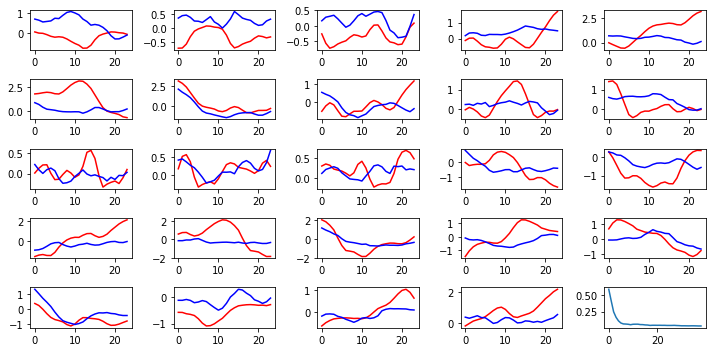

Step: 0, Train Loss: 0.01984943263232708
Step: 20, Train Loss: 0.032009731978178024
Step: 40, Train Loss: 0.01835368201136589
Step: 60, Train Loss: 0.0304812453687191
Step: 80, Train Loss: 0.03605595603585243
Step: 100, Train Loss: 0.021794795989990234
Step: 120, Train Loss: 0.014164707623422146
Step: 140, Train Loss: 0.018935900181531906
Epoch: 40, Train loss: 0.027355115095229997
acskill_socre:17.813599346724104, rmse_score:19.5679197677145
Epoch: 40, Valid Score: -1.7543204209903962


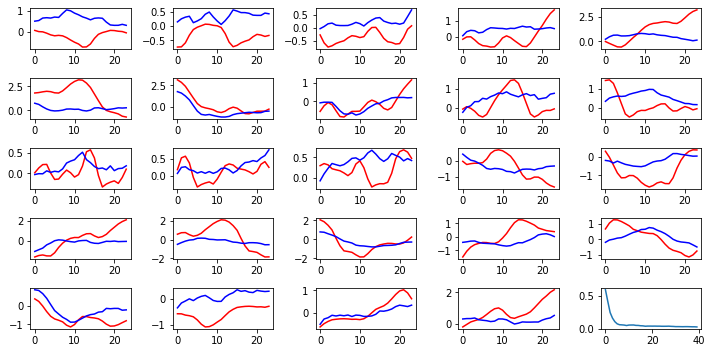

Step: 0, Train Loss: 0.03388030454516411
Step: 20, Train Loss: 0.024877486750483513
Step: 40, Train Loss: 0.023925697430968285
Step: 60, Train Loss: 0.026664573699235916
Step: 80, Train Loss: 0.01925739459693432
Step: 100, Train Loss: 0.017936766147613525
Step: 120, Train Loss: 0.022246215492486954
Step: 140, Train Loss: 0.020470689982175827
Epoch: 41, Train loss: 0.026170376012076255
acskill_socre:15.46156374531093, rmse_score:19.74666780023683
Epoch: 41, Valid Score: -4.285104054925899


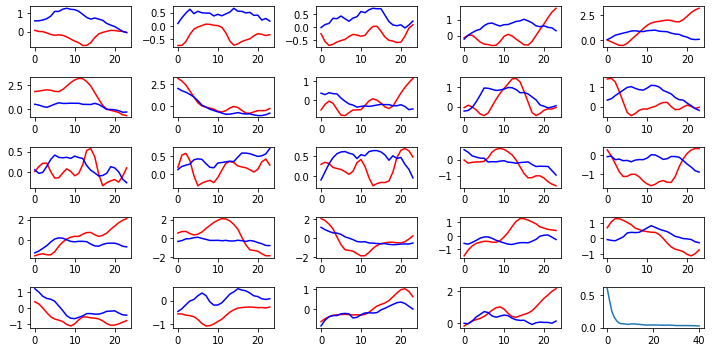

Step: 0, Train Loss: 0.02978600561618805
Step: 20, Train Loss: 0.019053777679800987
Step: 40, Train Loss: 0.019529100507497787
Step: 60, Train Loss: 0.023612236604094505
Step: 80, Train Loss: 0.027916379272937775
Step: 100, Train Loss: 0.018642686307430267
Step: 120, Train Loss: 0.027208223938941956
Step: 140, Train Loss: 0.01855839043855667
Epoch: 42, Train loss: 0.02670066496229743
acskill_socre:16.895810051409192, rmse_score:19.746609746364673
Epoch: 42, Valid Score: -2.85079969495548


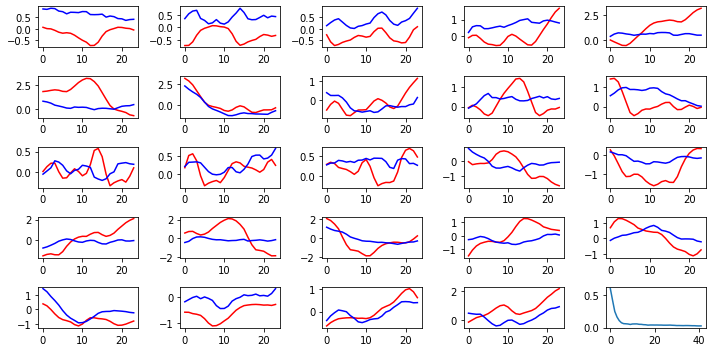

Step: 0, Train Loss: 0.018190208822488785
Step: 20, Train Loss: 0.031038282439112663
Step: 40, Train Loss: 0.040401190519332886
Step: 60, Train Loss: 0.028386350721120834
Step: 80, Train Loss: 0.03372231125831604
Step: 100, Train Loss: 0.025463342666625977
Step: 120, Train Loss: 0.022474443539977074
Step: 140, Train Loss: 0.028678294271230698
Epoch: 43, Train loss: 0.02626083627317662
acskill_socre:16.940314278970305, rmse_score:19.879399443681827
Epoch: 43, Valid Score: -2.9390851647115213


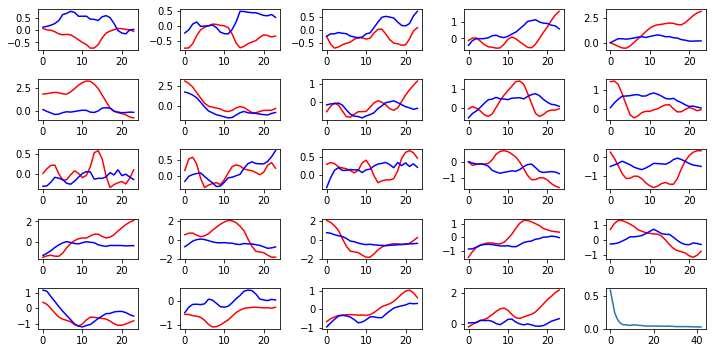

Step: 0, Train Loss: 0.04263189062476158
Step: 20, Train Loss: 0.022789951413869858
Step: 40, Train Loss: 0.020956218242645264
Step: 60, Train Loss: 0.017298728227615356
Step: 80, Train Loss: 0.030456937849521637
Step: 100, Train Loss: 0.03002980723977089
Step: 120, Train Loss: 0.029102277010679245
Step: 140, Train Loss: 0.0245193000882864
Epoch: 44, Train loss: 0.0244963786513736
acskill_socre:19.723837980785593, rmse_score:19.157346512407216
Epoch: 44, Valid Score: 0.566491468378377


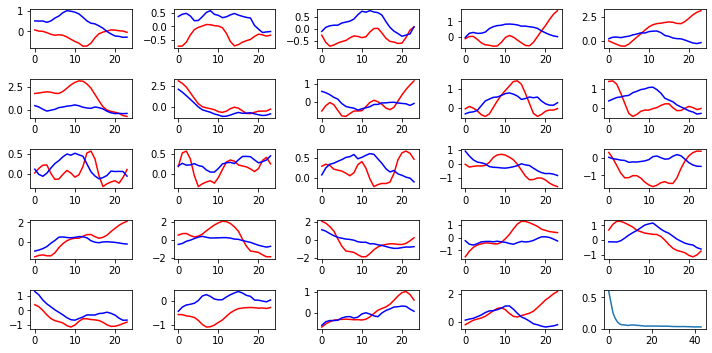

Step: 0, Train Loss: 0.01455731876194477
Step: 20, Train Loss: 0.02967747673392296
Step: 40, Train Loss: 0.023214910179376602
Step: 60, Train Loss: 0.022168349474668503
Step: 80, Train Loss: 0.024890605360269547
Step: 100, Train Loss: 0.021215414628386497
Step: 120, Train Loss: 0.01788458600640297
Step: 140, Train Loss: 0.02186412177979946
Epoch: 45, Train loss: 0.024400144330646894
acskill_socre:12.754690699698722, rmse_score:19.64057932557954
Epoch: 45, Valid Score: -6.885888625880819


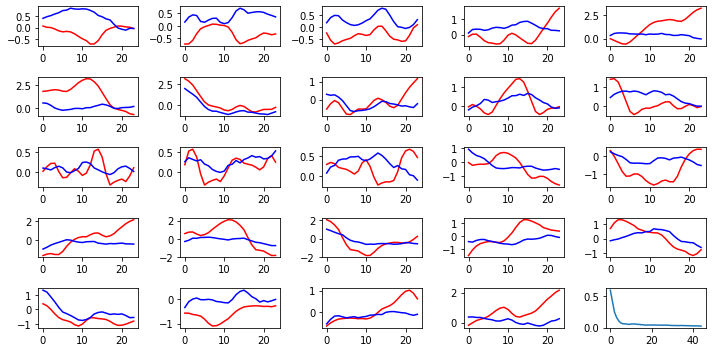

Step: 0, Train Loss: 0.015585560351610184
Step: 20, Train Loss: 0.02729792706668377
Step: 40, Train Loss: 0.031681954860687256
Step: 60, Train Loss: 0.028542613610625267
Step: 80, Train Loss: 0.027627594769001007
Step: 100, Train Loss: 0.021101733669638634
Step: 120, Train Loss: 0.01765047386288643
Step: 140, Train Loss: 0.01713329367339611
Epoch: 46, Train loss: 0.023712907318178923
acskill_socre:15.064279109304687, rmse_score:19.58603738691057
Epoch: 46, Valid Score: -4.521758277605882


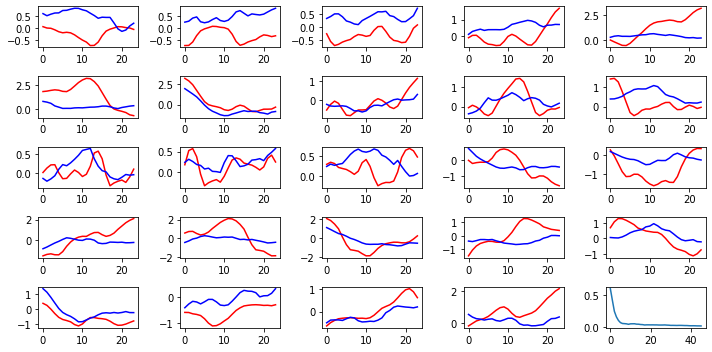

Step: 0, Train Loss: 0.02291242778301239
Step: 20, Train Loss: 0.02094167284667492
Step: 40, Train Loss: 0.030197758227586746
Step: 60, Train Loss: 0.017062416300177574
Step: 80, Train Loss: 0.031142394989728928
Step: 100, Train Loss: 0.02617686800658703
Step: 120, Train Loss: 0.02132498286664486
Step: 140, Train Loss: 0.021247372031211853
Epoch: 47, Train loss: 0.02473935410890677
acskill_socre:14.589186860461647, rmse_score:20.67901722988271
Epoch: 47, Valid Score: -6.089830369421064


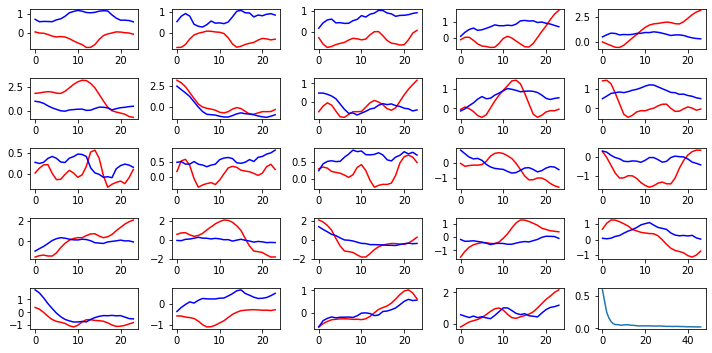

Step: 0, Train Loss: 0.020694926381111145
Step: 20, Train Loss: 0.03498992323875427
Step: 40, Train Loss: 0.024586867541074753
Step: 60, Train Loss: 0.02658766135573387
Step: 80, Train Loss: 0.022027550265192986
Step: 100, Train Loss: 0.02552349492907524
Step: 120, Train Loss: 0.02092912793159485
Step: 140, Train Loss: 0.02052953839302063
Epoch: 48, Train loss: 0.023486932312227683
acskill_socre:19.178842664197468, rmse_score:19.540181406939137
Epoch: 48, Valid Score: -0.361338742741669


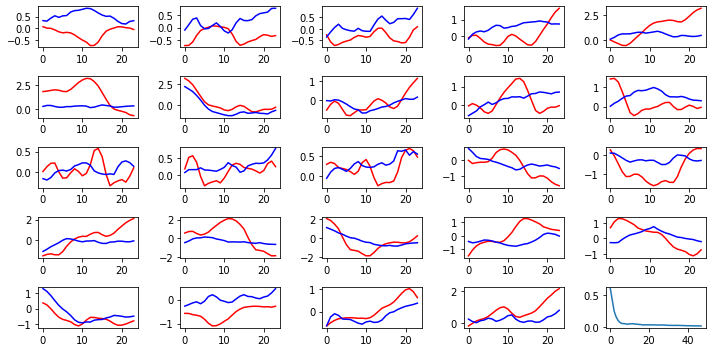

Step: 0, Train Loss: 0.021229257807135582
Step: 20, Train Loss: 0.02308061718940735
Step: 40, Train Loss: 0.027724456042051315
Step: 60, Train Loss: 0.02332492172718048
Step: 80, Train Loss: 0.017993466928601265
Step: 100, Train Loss: 0.023668861016631126
Step: 120, Train Loss: 0.01836264505982399
Step: 140, Train Loss: 0.02259657345712185
Epoch: 49, Train loss: 0.02260572352280764
acskill_socre:17.109317158033296, rmse_score:19.85532361686166
Epoch: 49, Valid Score: -2.746006458828365


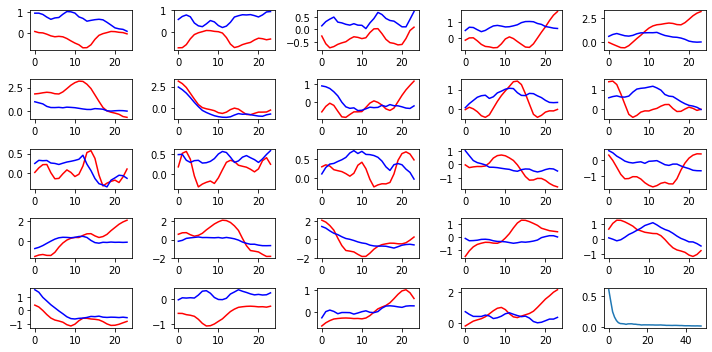

Step: 0, Train Loss: 0.02099699154496193
Step: 20, Train Loss: 0.032444458454847336
Step: 40, Train Loss: 0.02092304453253746
Step: 60, Train Loss: 0.025181500241160393
Step: 80, Train Loss: 0.027587052434682846
Step: 100, Train Loss: 0.018366651609539986
Step: 120, Train Loss: 0.022189786657691002
Step: 140, Train Loss: 0.013328502885997295
Epoch: 50, Train loss: 0.022446612648870032
acskill_socre:16.55857086133101, rmse_score:19.74467986653557
Epoch: 50, Valid Score: -3.1861090052045604


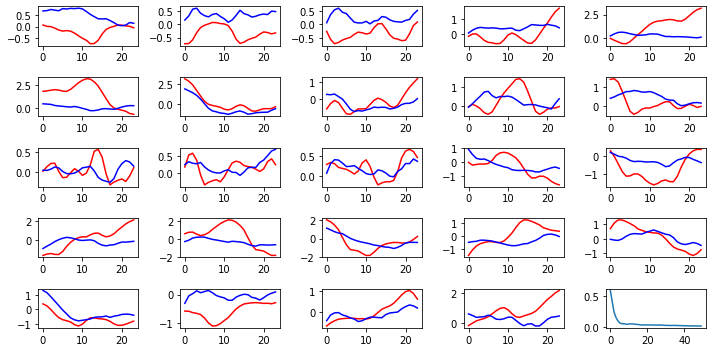

In [16]:
train(num_epochs=50)

In [94]:
model.load_state_dict(torch.load('models/basemodel_epoch_5.pt'))

<All keys matched successfully>

In [15]:
test_path = './tcdata/enso_round1_test_20210201/'

### load test data
files = os.listdir(test_path)
test_feas_dict = {}
for file in files:
    test_feas_dict[file] = np.load(test_path + file)

In [16]:
### 2. predict
test_predicts_dict = {}
for file_name, val in test_feas_dict.items():
    SST = np.expand_dims(val[:,:,:,0],axis=0)
    T300 = np.expand_dims(val[:,:,:,1],axis=0)
    Ua = np.expand_dims(val[:,:,:,2],axis=0)
    Va = np.expand_dims(val[:,:,:,3],axis=0)
    
    SST = np.nan_to_num(SST) # trans nan to 0
    T300 = np.nan_to_num(T300)
    Ua = np.nan_to_num(Ua)
    Va = np.nan_to_num(Va)
    
    data_list = [SST,T300,Ua,Va]
    SST,T300,Ua,Va = fit_data(data_list, fit=False)

    SST = torch.tensor(SST).to(device).float()
    T300 = torch.tensor(T300).to(device).float()
    Ua = torch.tensor(Ua).to(device).float()
    Va = torch.tensor(Va).to(device).float()
    
    result = model(SST, T300, Ua, Va).view(-1).detach().cpu().numpy()
    test_predicts_dict[file_name] = result

(20736, 4)


In [17]:
### 3. save results
if os.path.exists('./result/'):  
    shutil.rmtree('./result/', ignore_errors=True)  
os.makedirs('./result/')
for file_name, val in test_predicts_dict.items(): 
    np.save('./result/' + file_name, val)

In [18]:
def make_zip(res_dir='./result', output_dir='result.zip'):  
    z = zipfile.ZipFile(output_dir, 'w')  
    for file in os.listdir(res_dir):  
        if '.npy' not in file:
            continue
        z.write(res_dir + os.sep + file)  
    z.close()

In [19]:
make_zip()